In [ ]:
import pandas as pd
import numpy as np
import pandas as pd

from OptimalHedging.GBM import GBMSimulator  # conforme você pediu

# -----------------------------
# 0) Parâmetros
# -----------------------------
M     = 1000
N     = 252
K     = 150.0
S0    = 100.0
T     = 1.0
t0    = 0.0
mu    = 0.05
sigma = 0.2

gamma = 2.0
a     = 2.0
k     = 2.0
beta  = 0.95
U = 10.0

np.random.seed(123)

t_idx = 0.2

# -----------------------------
# 1) Instancia + simula S e H
# -----------------------------
sim = GBMSimulator(
    M=M, N=N, K=K, S0=S0, T=T, t0=t0, mu=mu, sigma=sigma
)

sim.simulate_S()
sim.simulate_H()

# -----------------------------
# 2) Riscos: definição de kwargs
# -----------------------------
risk_specs = {
    "ele" : {"a": a},
    "elw" : {"k": k, "U": U},
    "entl": {"gamma": gamma, "U": U},
    "ente": {"gamma": gamma, "a": a, "U": U},
    "entw": {"gamma": gamma, "k": k, "U": U},
    "esl" : {"beta": beta},
}

# Ordem de avaliação nas colunas (igual ao print do exemplo)
eval_order = ["ele", "elw", "entl", "ente", "entw", "esl"]

# -----------------------------
# 3) Loop: otimiza e avalia
# -----------------------------
rows = []
hedges = {}

for risk_type, risk_kwargs in risk_specs.items():
    MR, info = sim.compute_MR(
        t_idx=t_idx,
        risk_type=risk_type,
        risk_kwargs=risk_kwargs,
        max_iter=20,
        tol=1e-4,
        alpha=1e-3,
        verbose=True
    )

    rows.append({
        "Model": "GBM",
        "Risk": risk_type,
        "t_idx": t_idx,
        "MR": MR,
        "rho_T": info["rho_T"],
        "rho_t": info["rho_t"],
    })

df_MR = pd.DataFrame(rows)

pd.set_option("display.float_format", lambda x: f"{x:.6f}")
display(df_MR)


In [ ]:
# fixa K e hedge (para não misturar efeitos)
sim.K = 10.0
sim.simulate_H()
h, _ = sim.optimize_hedge(
    risk_type="esl",
    risk_kwargs={"beta": 0.95},
    t_idx=0.0,
    verbose=False
)

# dois tempos distintos
t1 = 0.2
t2 = 0.8

L_t1 = sim.forward_PL(h, L0=0.0, t_start=t1)
L_t2 = sim.forward_PL(h, L0=0.0, t_start=t2)

# plota um cenário
import matplotlib.pyplot as plt
plt.plot(L_t1[0], label=f"t={t1}")
plt.plot(L_t2[0], label=f"t={t2}")
plt.legend()
plt.title("P&L paths (same hedge, different t)")
plt.show()


K=8.0000 | m=1.250 | t=0.000
K=8.0000 | m=1.250 | t=0.050
K=8.0000 | m=1.250 | t=0.100
K=8.0000 | m=1.250 | t=0.150
K=8.0000 | m=1.250 | t=0.200
K=8.0000 | m=1.250 | t=0.250
K=8.0000 | m=1.250 | t=0.300
K=8.0000 | m=1.250 | t=0.350
K=8.0000 | m=1.250 | t=0.400
K=8.0000 | m=1.250 | t=0.450
K=8.0000 | m=1.250 | t=0.500
K=8.0000 | m=1.250 | t=0.550
K=8.0000 | m=1.250 | t=0.600
K=8.0000 | m=1.250 | t=0.650
K=8.0000 | m=1.250 | t=0.700
K=8.0000 | m=1.250 | t=0.750
K=8.0000 | m=1.250 | t=0.800
K=8.0000 | m=1.250 | t=0.850
K=8.0000 | m=1.250 | t=0.900
K=8.0000 | m=1.250 | t=0.950
K=8.0000 | m=1.250 | t=1.000
K=8.4000 | m=1.190 | t=0.000
K=8.4000 | m=1.190 | t=0.050
K=8.4000 | m=1.190 | t=0.100
K=8.4000 | m=1.190 | t=0.150
K=8.4000 | m=1.190 | t=0.200
K=8.4000 | m=1.190 | t=0.250
K=8.4000 | m=1.190 | t=0.300
K=8.4000 | m=1.190 | t=0.350
K=8.4000 | m=1.190 | t=0.400
K=8.4000 | m=1.190 | t=0.450
K=8.4000 | m=1.190 | t=0.500
K=8.4000 | m=1.190 | t=0.550
K=8.4000 | m=1.190 | t=0.600
K=8.4000 | m=1

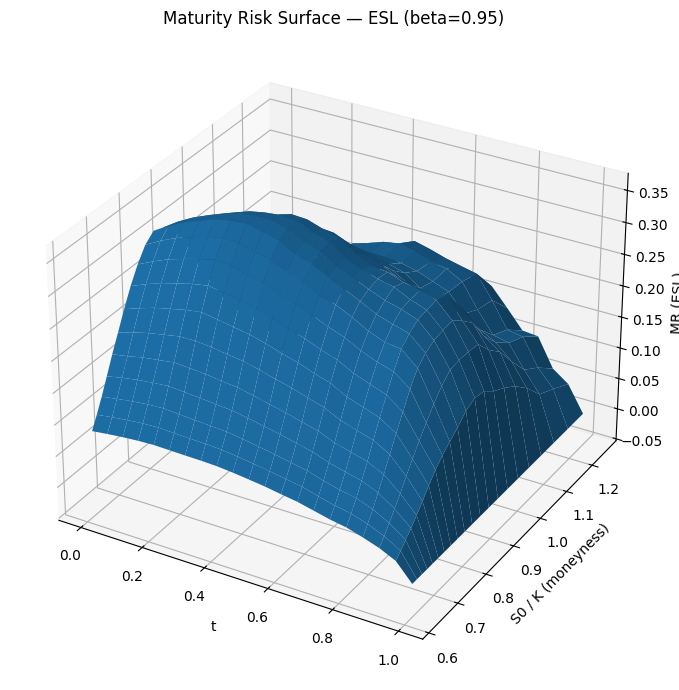

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

from OptimalHedging.GBM import GBMSimulator

# ============================================================
# 0) Parâmetros do experimento
# ============================================================
# Processo
M     = 1000
N     = 252
S0    = 10.0
T     = 1.0
t0    = 0.0
mu    = 0.05
sigma = 0.2

# Risco (ESL)
risk_type   = "esl"
beta        = 0.95
risk_kwargs = {"beta": beta}

# Malhas (tempo e moneyness)
# Você pediu t em [0, 1]. Observação: t=T pode ficar degenerado (MR ~ 0/ruído numérico).
n_t = 21
n_k = 21
t_grid = np.linspace(t0, T, n_t)                # inclui T
K_grid = np.linspace(S0 * 0.8, S0 * 1.6, n_k)   # garante moneyness em [0.8, 1.6]
# equivalente a K em [6.25, 12.5] quando S0=10

# Otimização
max_iter = 20
tol      = 1e-4
alpha    = 1e-3
verbose  = False

np.random.seed(123)

# ============================================================
# 1) Simulação do GBM (fixa para toda a superfície)
# ============================================================
# K inicial é placeholder; vamos sobrescrever dentro do loop
sim = GBMSimulator(M=M, N=N, K=K_grid[0], S0=S0, T=T, t0=t0, mu=mu, sigma=sigma)
sim.simulate_S()

# ============================================================
# 2) Loop duplo: (K, t) -> MR
# ============================================================
rows = []
for K in K_grid:
    sim.K = float(K)
    sim.simulate_H()  # payoff depende de K

    for t in t_grid:
        print(f"K={K:.4f} | m={S0/K:.3f} | t={t:.3f}")
        MR, info = sim.compute_MR(
            t_idx=float(t),              # aqui é TEMPO (não índice)
            risk_type=risk_type,
            risk_kwargs=risk_kwargs,
            max_iter=max_iter,
            tol=tol,
            alpha=alpha,
            verbose=verbose
        )

        rows.append({
            "t": float(t),
            "K": float(K),
            "moneyness": float(S0 / K),
            "MR": float(MR),
            "rho_T": float(info["rho_T"]),
            "rho_t": float(info["rho_t"]),
        })

df = pd.DataFrame(rows)

# ============================================================
# 3) Pivot para malhas 2D (moneyness x tempo)
# ============================================================
# Linhas = moneyness, colunas = t
pivot = df.pivot_table(index="moneyness", columns="t", values="MR", aggfunc="mean")

m_vals = pivot.index.to_numpy()
t_vals = pivot.columns.to_numpy()

T_mesh, M_mesh = np.meshgrid(t_vals, m_vals)
MR_mesh = pivot.to_numpy()

# ============================================================
# 4) Gráfico 3D (superfície)
# ============================================================
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(T_mesh, M_mesh, MR_mesh, linewidth=0, antialiased=True)

ax.set_xlabel("t")
ax.set_ylabel("S0 / K (moneyness)")
ax.set_zlabel("MR (ESL)")

ax.set_title(f"Maturity Risk Surface — ESL (beta={beta})")

plt.tight_layout()
plt.show()

# ============================================================
# 5) (Opcional) salvar resultados
# ============================================================
# df.to_csv("mr_surface_esl.csv", index=False)
# pivot.to_csv("mr_surface_esl_pivot.csv")


In [12]:
import plotly.graph_objects as go
import plotly.io as pio

# força renderização no navegador (independente de Jupyter)
pio.renderers.default = "browser"

fig = go.Figure(
    data=[
        go.Surface(
            x=T_mesh,
            y=M_mesh,
            z=MR_mesh,
            colorscale="RdBu",
            reversescale=True,
            opacity=0.95,
            contours=dict(
                z=dict(
                    show=True,
                    usecolormap=True,
                    highlightcolor="black",
                    project=dict(z=True)
                )
            ),
            showscale=True
        )
    ]
)

fig.update_layout(
    title="Maturity Risk Surface (ESL)",
    width=950,
    height=750,
    scene=dict(
        xaxis_title="t",
        yaxis_title="S0 / K (moneyness)",
        zaxis_title="MR",
        xaxis=dict(backgroundcolor="white"),
        yaxis=dict(backgroundcolor="white"),
        zaxis=dict(backgroundcolor="white"),
        camera=dict(
            eye=dict(x=1.6, y=1.6, z=0.9)
        )
    )
)

fig.show()
